# 캘리포니아 집값 데이터

캘리포니아 집값 데이터로부터 예측하기

## 1. 데이터 수집 및 탐색, 전처리

In [43]:
import pandas as pd

housing = pd.read_csv("housing.csv")

In [44]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 분석 목적
1990년 인구 조사에서 파생된 캘리포니아 지역의 중앙 주택 가격을 기반으로 현재 주택 가격 예측하기

### 회귀 모델 후보  
[1] 선형 회귀 [2] 다항 회귀 [3] 릿지 회귀/라쏘 회귀/엘라스틱넷(다중공선성 존재)  
[4] 서포트벡터머신

### 데이터 구조 확인
결측치, 중복값, 타입, 스케일링, 상관관계(다중공선성 확인)

In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [46]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Ocean Proximity는 범주형 카테고리 -> 수치형으로 변환해야함  
target 데이터는 median_house_value(집값 가치)

In [47]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [48]:
cnt = 0
for idx, dup in enumerate(housing.duplicated()):
    if dup == True:
        cnt += 1
        
if cnt == 0:
    print("no duplicated")
else:
    print("duplicated number: {}".format(cnt))

no duplicated


In [49]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


결측치와 중복값은 없지만, 스케일링 조정이 필요함

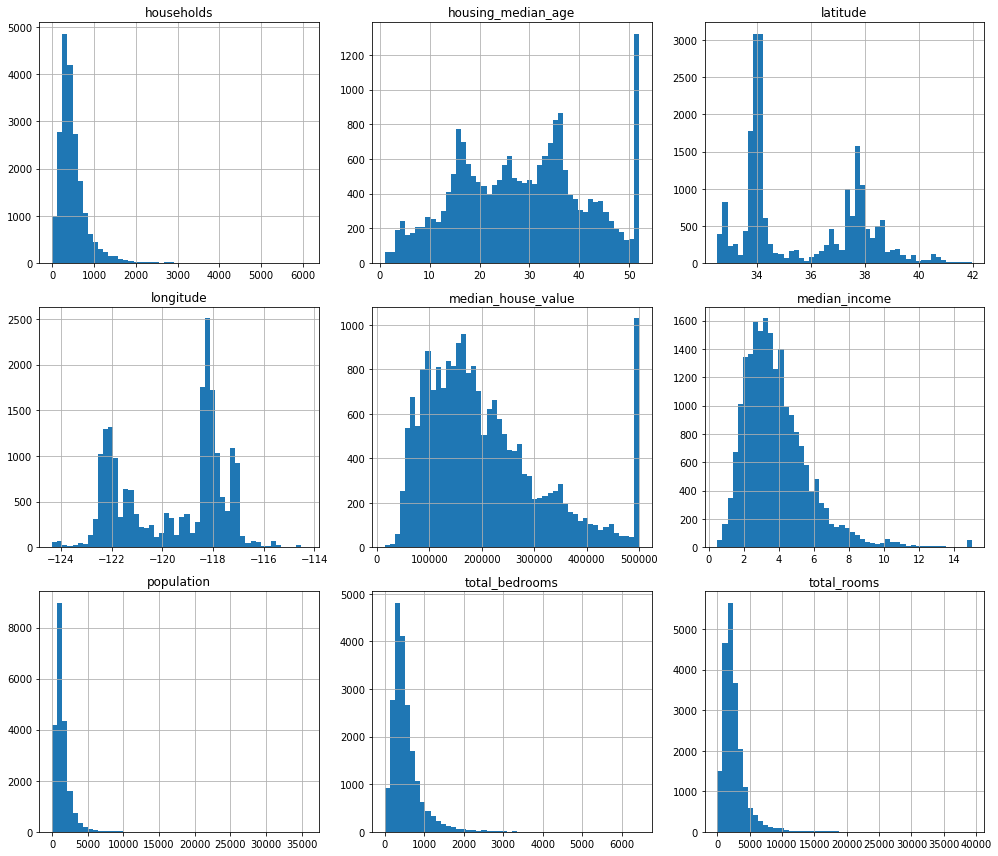

In [50]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(14, 12))
plt.tight_layout()
plt.show()

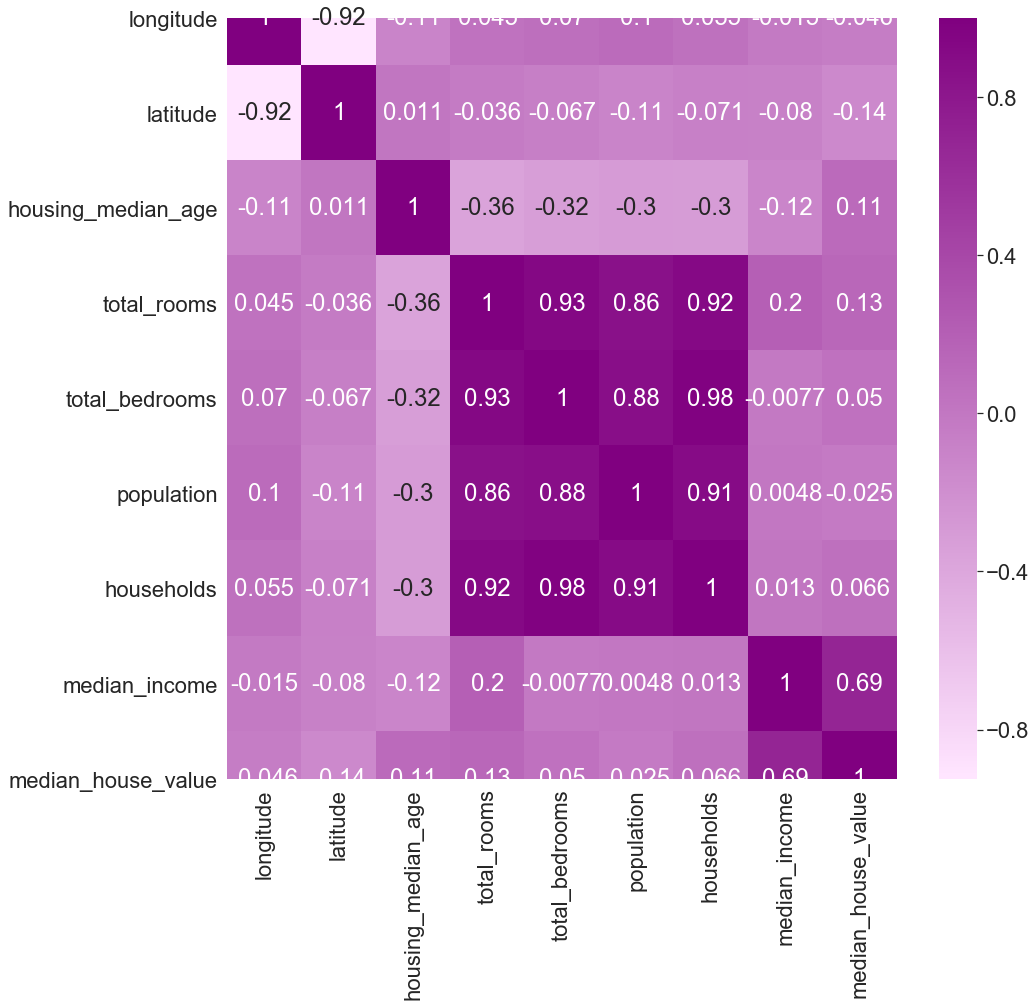

In [51]:
# 히트맵으로 다중공선성 확인
import seaborn as sns

plt.figure(figsize=(15, 14))
cmap = sns.light_palette("purple", as_cmap=True)
sns.set(font_scale=2)
sns.heatmap(housing.corr(), annot=True, cmap=cmap)
plt.show()

눈으로 보기엔 다중공선성이 많지 않아보임

### 훈련 데이터, 테스트 데이터 나누기
+ 계층 샘플링을 사용하기  
+ 새로운 income_cat 특성 만들기

In [52]:
import numpy as np

housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [54]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

In [55]:
strat_train_set.to_csv("strat_train_set.csv", index=False)
strat_test_set.to_csv("strat_test_set.csv", index=False)

### 훈련 데이터 탐색

In [56]:
train_data = pd.read_csv("strat_train_set.csv")

In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


Text(0.5, 1.0, 'Distribution of households')

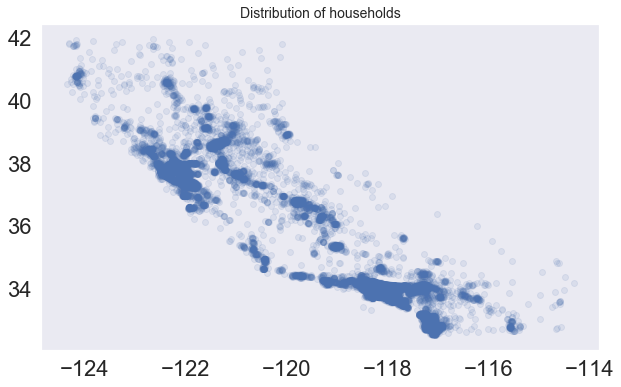

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_data['longitude'], train_data['latitude'], alpha=0.1)
plt.grid(False)
plt.title("Distribution of households", size=14)

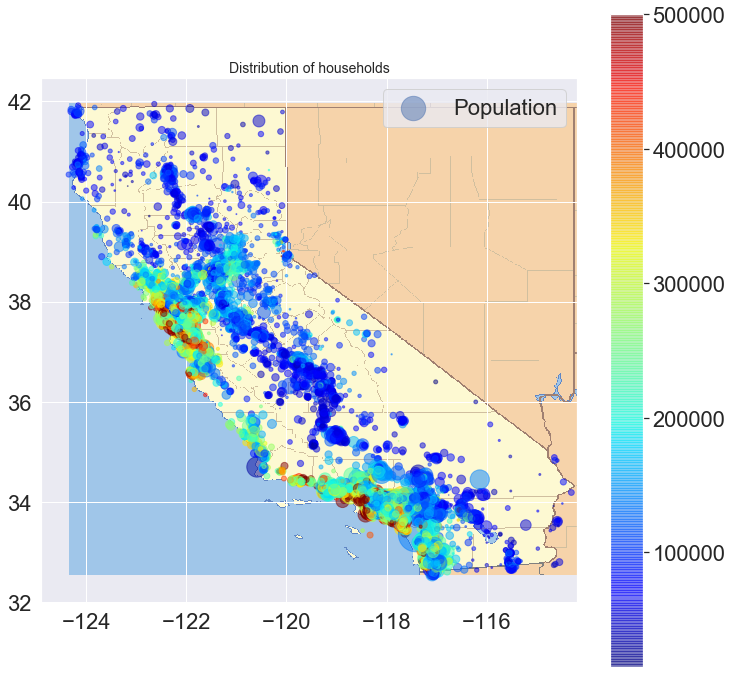

In [59]:
plt.figure(figsize=(12, 12))
img = plt.imread("california.png")

plt.imshow(img, zorder=0, extent=[-124.35, -114.2, 32.54, 41.95])

plt.scatter(train_data['longitude'], train_data['latitude'], alpha=0.5,
            s=train_data["population"]/30, c=train_data["median_house_value"],
            cmap=plt.get_cmap("jet"), zorder=1, label="Population")
plt.colorbar()
plt.title("Distribution of households", size=14)
plt.legend()

위의 데이터 시각화를 통해 알 수 있는 사실
+ target data(집값, 100,000단위임)는 위치와 인구 밀도와 관련되어 보임
+ target data는 북부를 제외하고 해안으로 갈 수록 비싸짐

### 데이터 상관관계 확인

In [60]:
corr_matrix = train_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

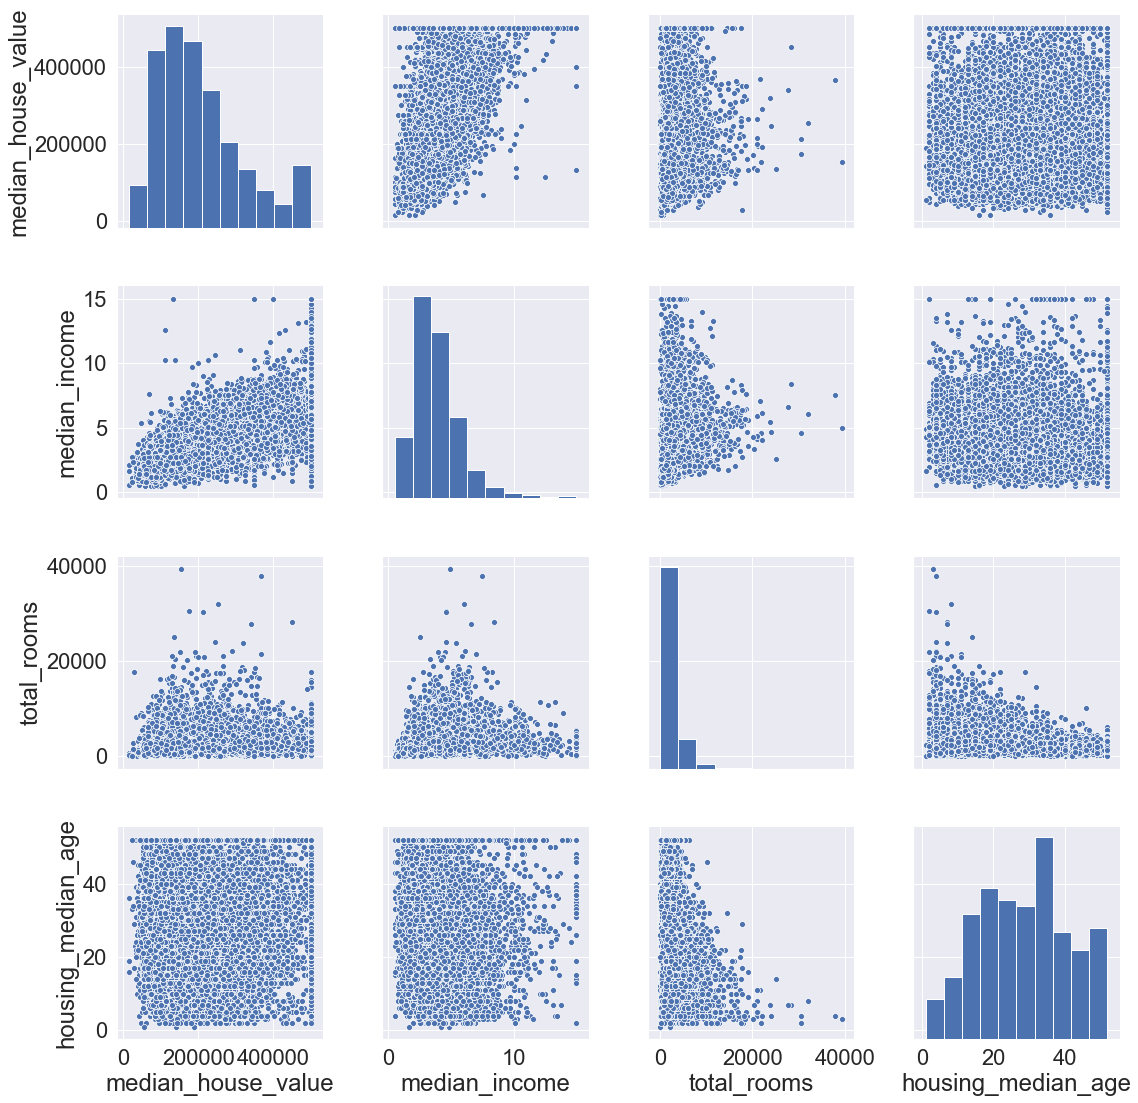

In [61]:
import seaborn as sns

sns.pairplot(train_data[['median_house_value','median_income','total_rooms','housing_median_age']], height=4)

Median Imcome이 가장 집값(target) 데이터와의 관계를 얻을 수 있는 유망한 속성

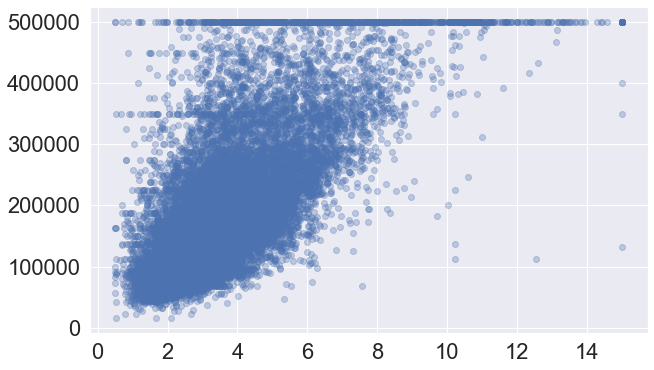

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(y=train_data['median_house_value'], x=train_data['median_income'], alpha=0.3)

y축의 5와 3, 4사이에서 선을 볼 수 있는데, 이러한 데이터는 모델의 성능을 저하시킬 수 있음

### 새로운 특성 만들기
+ rooms per household      // 한 가구 당 집 수
+ bedrooms per room        // 한 집 당 방 수
+ population per household // 한 가구 당 인구 수

In [63]:
train_data1 = train_data.copy()

In [64]:
train_data1['rooms_per_household'] = train_data1['total_rooms'] / train_data1['households']
train_data1['bedrooms_per_room'] = train_data1['total_bedrooms'] / train_data1['total_rooms']
train_data1['population_per_household'] = train_data1['population'] / train_data1['households']

In [65]:
train_data1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [66]:
corr_matrix = train_data1.corr()

In [67]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

rooms_per_occup와 bedrooms_per_room이 AveRooms와 AveOccup보다 집값 데이터와 관계성이 높은 것을 알 수 있다.

### 특성 추가를 위한 파이프라인

In [68]:
from sklearn.base import BaseEstimator,TransformerMixin

class FeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        X['population_per_household'] = X['population'] / X['households']
        return X

### 결측치 데이터 처리

In [69]:
def get_null_count(data):
    for i in data.columns:
        print(i, ': ', len(data[data[i].isnull()][i]))

In [70]:
get_null_count(train_data)

longitude :  0
latitude :  0
housing_median_age :  0
total_rooms :  0
total_bedrooms :  158
population :  0
households :  0
median_income :  0
median_house_value :  0
ocean_proximity :  0


In [71]:
train_data_null = train_data[train_data['total_bedrooms'].isnull()]

No handles with labels found to put in legend.


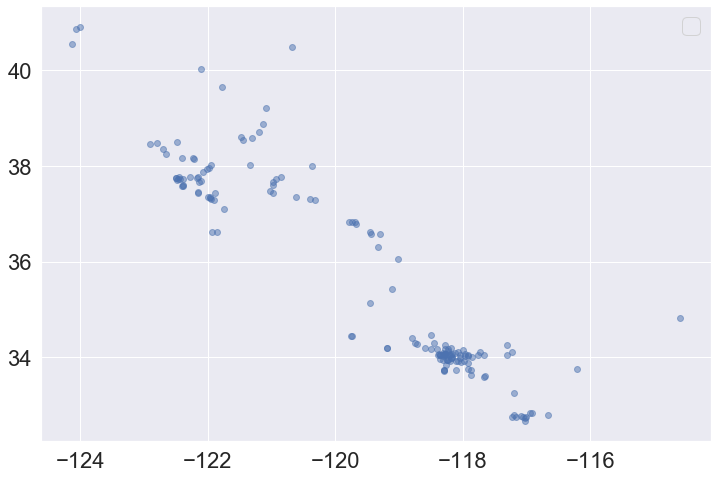

In [72]:
plt.figure(figsize=(12, 8))
plt.scatter(x=train_data_null['longitude'], y=train_data_null['latitude'], alpha=0.5)
plt.legend()

딱히 널값의 분포에 특정한 패턴이 보이지 않음

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018B67E7F9B0>]],
      dtype=object)

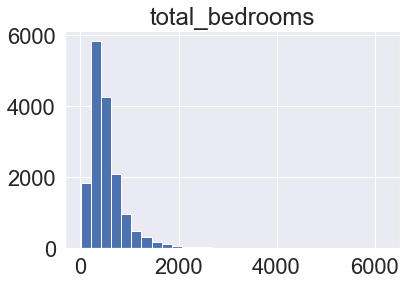

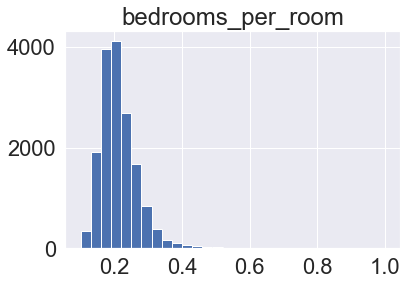

In [73]:
train_data1.hist(column='total_bedrooms', bins=30)
train_data1.hist(column='bedrooms_per_room', bins=30)

결측치가 있었다면 sklearn의 Imputer를 사용해서 중간값으로 채우기

### 이상치 제거

In [74]:
num_features = train_data1.columns.values.tolist()
num_features.remove('ocean_proximity')

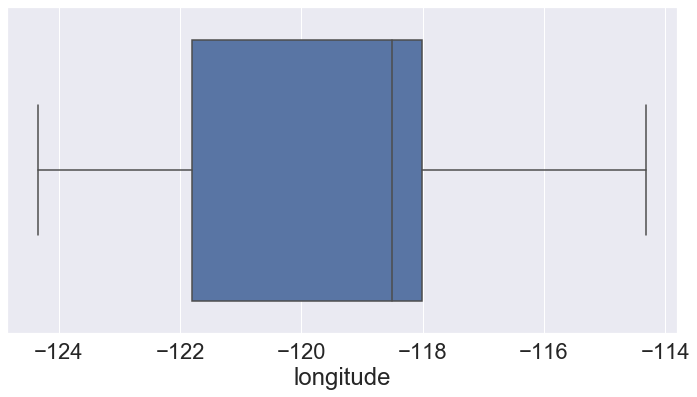

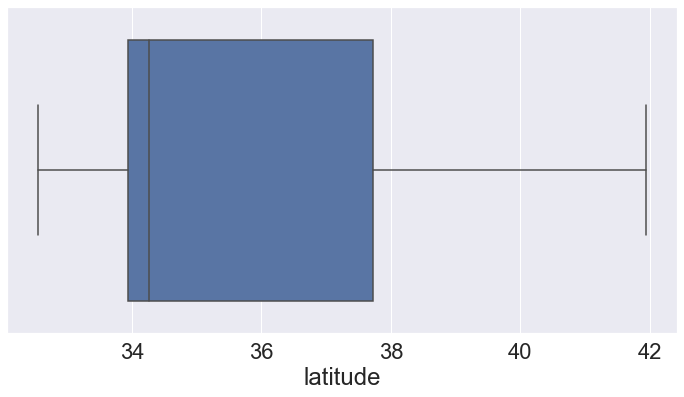

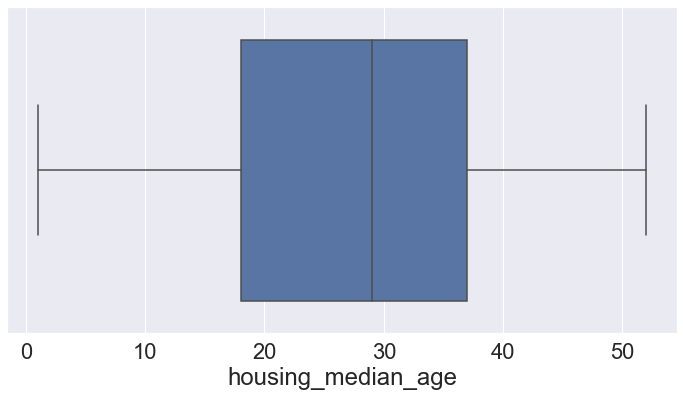

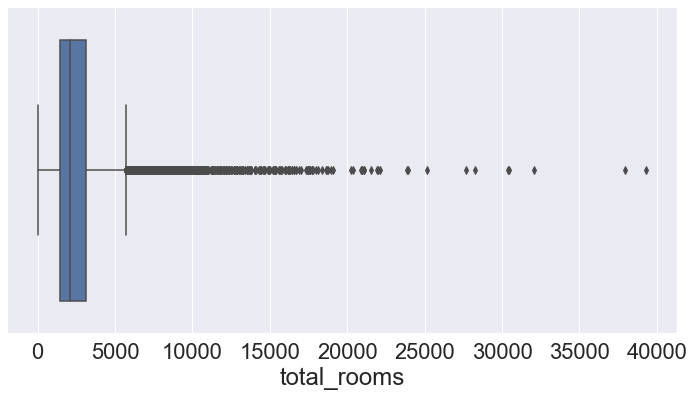

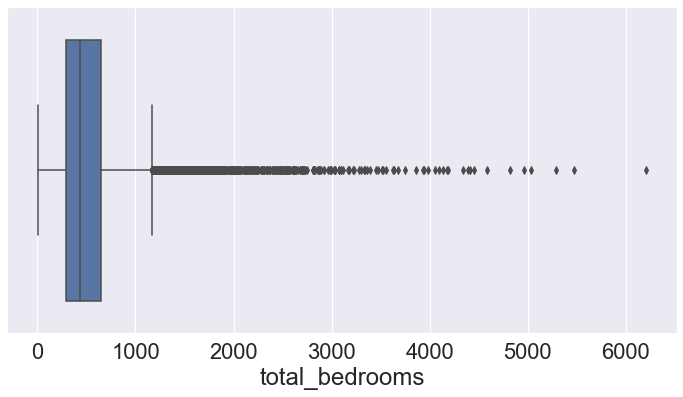

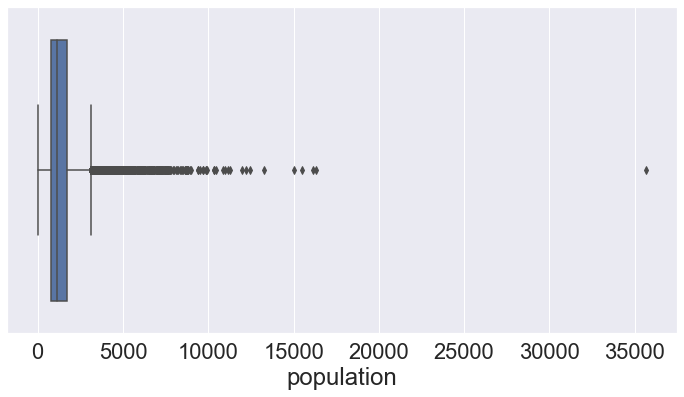

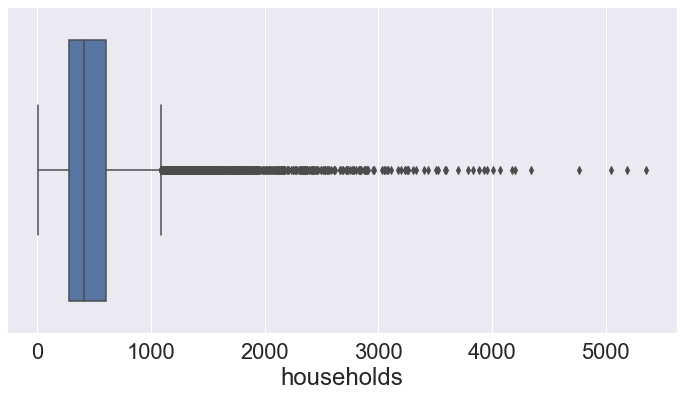

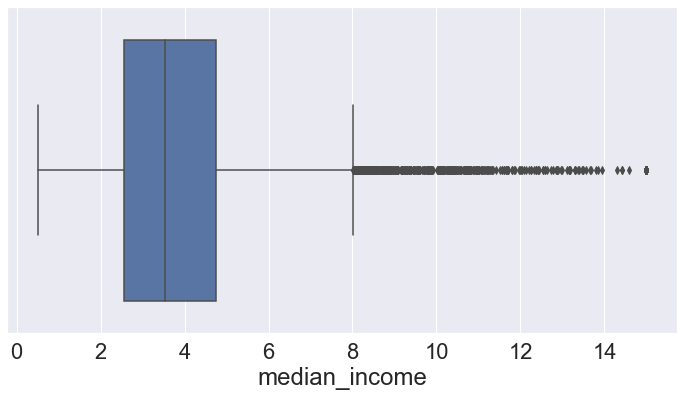

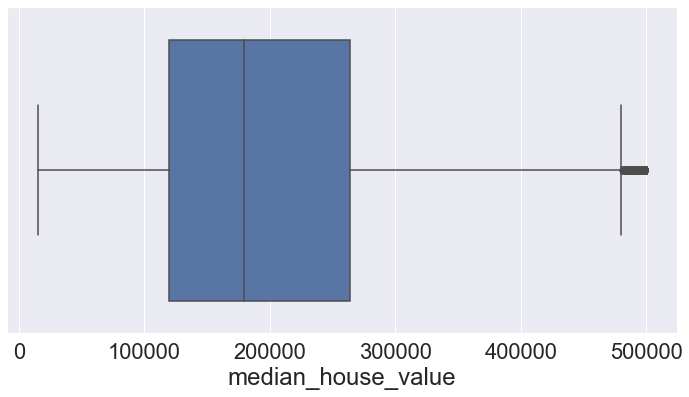

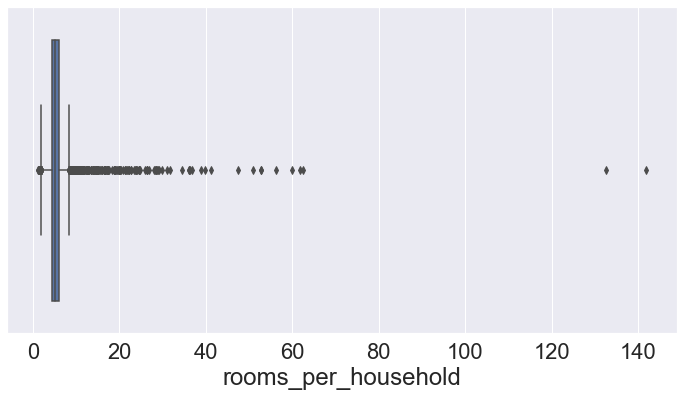

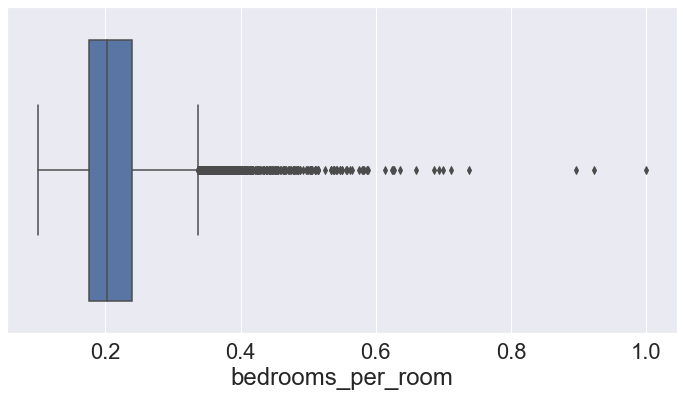

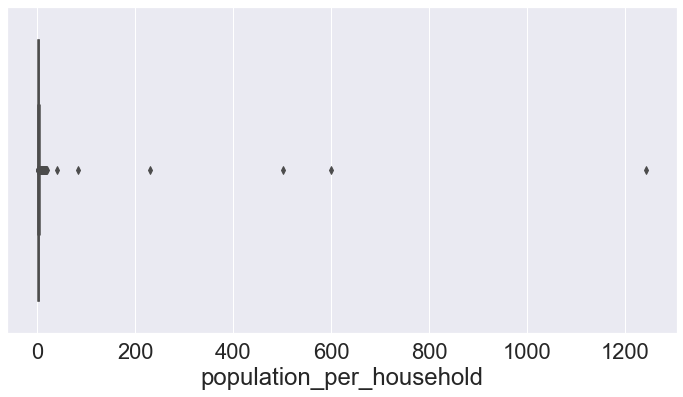

In [75]:
for i in num_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    sns.boxplot(x=i, data=train_data1, ax=ax)

In [76]:
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        X=X[(X['median_house_value']!=500001) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[X['median_income']<=11].reset_index(drop=True)
        X=X[(X['median_house_value']!=350000) | (X['median_income']>=1.5)].reset_index(drop=True)
        X=X[(X['median_house_value']!=450000) | (X['median_income']>=2)].reset_index(drop=True)
        X=X[(X['median_house_value']>=350000) | (X['median_income']<=9.5)].reset_index(drop=True)
        X=X[X['population']<=9000]
        X=X[(X['population_per_household']>=1.15) & (X['population_per_household']<=6.5)]
        X=X[X['rooms_per_household']<20]
        X=X[X['bedrooms_per_room']<0.5].reset_index(drop=True)
        return X

In [77]:
train_data1 = RemoveOutliers().fit_transform(train_data1)

In [78]:
train_data_labels = train_data1['median_house_value']
train_data1 = train_data1.drop('median_house_value', axis=1)

In [79]:
train_data1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,0.223852,2.094395
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.008850,0.159057,2.707965
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,0.241291,2.025974
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,0.200866,4.135977
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...
16000,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND,6.052381,0.185681,2.728571
16001,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND,4.635659,0.245819,4.077519
16002,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND,6.346405,0.179609,2.742484
16003,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN,5.505618,0.193878,3.808989


### 왜도 값 변환
왜도(skewness)는 일련의 데이터에서 대칭 벨 곡선 또는 정규 분포의 왜곡 또는 비대칭을 나타냄. 커브가 왼쪽이나 오른쪽으로 이동하면 기울어 졌다고 함. 왜도는 주어진 분포가 정규 분포와 다른 정도를 나타내는 것으로 정량화 할 수 있음.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018B6BDA7C88>,
      dtype=object)

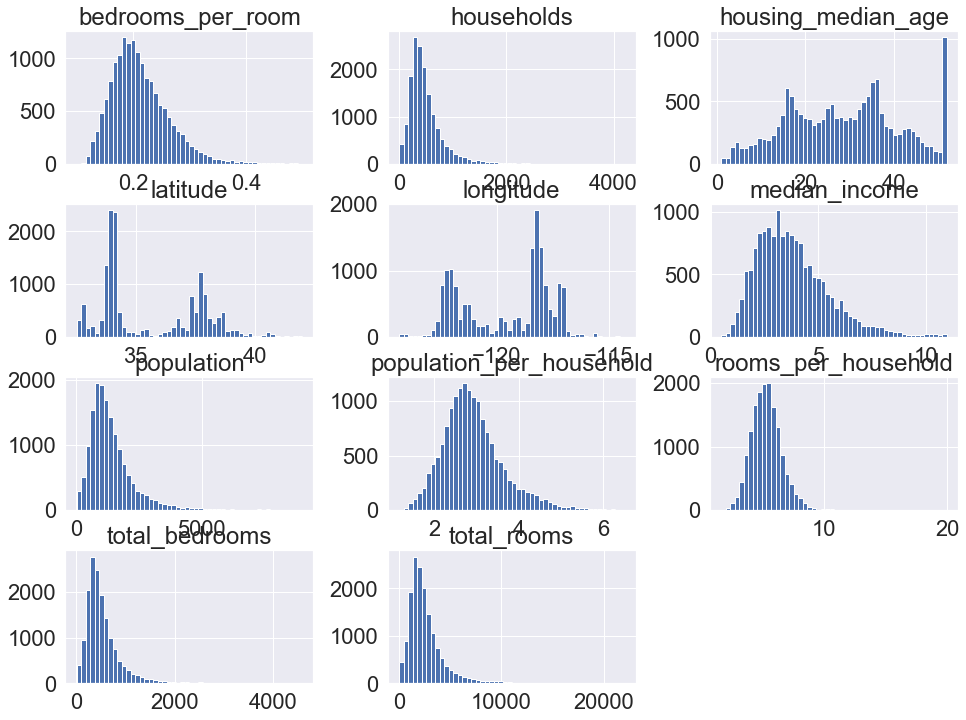

In [80]:
train_data1.hist(bins=50, figsize=(16, 12))

In [81]:
num_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [82]:
num_features.remove('median_house_value')

In [83]:
skewness = []
for i in num_features:
    skewness.append(train_data1[i].skew())

pd.DataFrame(data=skewness, index=num_features, columns=['skewness']).sort_values(by='skewness', ascending=False)

,skewness
total_rooms,2.902649
total_bedrooms,2.684070
households,2.629067
population,2.453927
rooms_per_household,2.168956
bedrooms_per_room,1.158469
median_income,1.051412
population_per_household,0.902046
latitude,0.462198
housing_median_age,0.061121


log1p와 boxcox1p 함수를 사용해서 skewed 기능 사용

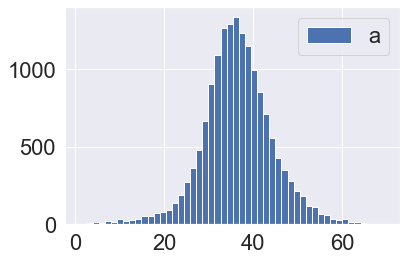

In [84]:
import numpy as np

train_data1['households'].apply(lambda x : np.log1p(x)**2).hist(bins=50, label='a')
plt.legend()

In [85]:
class FeaturesTransformer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        import numpy as np
        from scipy.special import boxcox1p        
        X['total_rooms']=X['total_rooms'].apply(lambda x: boxcox1p(x,0.25))
        X['total_bedrooms']=X['total_bedrooms'].apply(lambda x: boxcox1p(x,0.25))
        X['households']=X['households'].apply(lambda x: boxcox1p(x,0.2))
        X['population']=X['population'].apply(lambda x: boxcox1p(x,0.3))
        X['rooms_per_household']=X['rooms_per_household'].apply(lambda x: np.log1p(x)**0.5)
        X['bedrooms_per_room']=X['bedrooms_per_room'].apply(lambda x: np.log1p(x)**0.25)
        X['median_income']=X['median_income'].apply(lambda x: np.log1p(x)**1.25)
        X['population_per_household']=X['population_per_household'].apply(lambda x: np.log1p(x)**1)
        return X

In [86]:
train_data1 = FeaturesTransformer().fit_transform(train_data1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018B6AF9B438>,
      dtype=object)

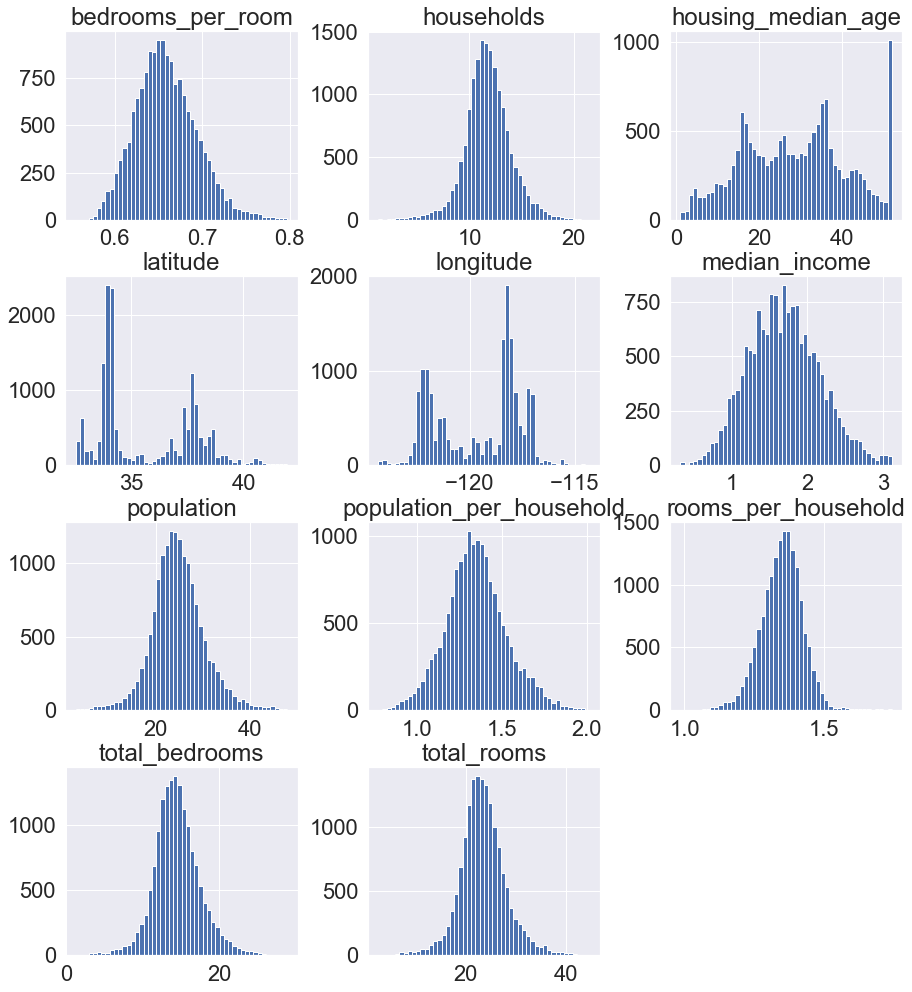

In [87]:
train_data1.hist(bins=50, figsize=(15, 17))

### 더미 변수 및 특성 스케일링

In [88]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class DataFrameSelector(BaseEstimator,TransformerMixin):
    """This class is a dataframe selector.
        Data members:
            features: A list of column_names you want in output dataframe
    """
    def __init__(self,features):
        self.features=features
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.features]

In [89]:
class GetDummies(BaseEstimator,TransformerMixin):
    """This class is used to get dummy columns from categorical columns."""
    
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        X[X=='ISLAND']='NEAR BAY'
        return (pd.get_dummies(X,drop_first=True))

In [90]:
cat_features = ['ocean_proximity']

In [91]:
# 수치형 변환 파이프라인
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy='median')), # 결측치값을 중간값으로 채우기
    ('std_scaler', StandardScaler())
])

# 범주형 변환 파이프라인
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('get_dummies', GetDummies())
])

# 수치형과 범주형 변환 파이프라인
data_cleaning_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [92]:
train_data1 = data_cleaning_pipeline.fit_transform(train_data1)

c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [93]:
train_data1

array([[-1.15422382,  0.7725674 ,  0.74637028, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17418   ,  0.66036107, -1.17101925, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18563844, -1.34065183,  0.18713167, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58476206, -0.72351701, -1.5704754 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78152577, -0.84974913,  0.18713167, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43361035,  0.99698006,  1.8648475 , ...,  0.        ,
         1.        ,  0.        ]])

In [94]:
I = num_features.copy()
I.extend([0, 1, 2])

In [95]:
train_data1 = pd.DataFrame(train_data1, columns=I)

In [96]:
train_data1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,0,1,2
0,-1.154224,0.772567,0.746370,-0.475425,-0.369225,-0.743301,-0.314063,-0.611150,-0.449849,0.334068,-1.207634,0.0,0.0,0.0
1,-1.174180,0.660361,-1.171019,-1.491029,-1.797235,-1.693043,-1.732155,1.464804,0.622682,-1.106072,-0.204224,0.0,0.0,0.0
2,1.185638,-1.340652,0.187132,-0.172520,0.058526,-0.375164,0.146097,-0.492940,-0.825039,0.659921,-1.331664,0.0,0.0,1.0
3,-0.016721,0.314392,-0.292216,-0.250552,-0.291022,0.285178,-0.255531,-1.299468,0.057913,-0.130596,1.602935,1.0,0.0,0.0
4,0.492161,-0.658063,-0.931346,1.849185,2.120810,2.390008,2.135415,-0.368150,-0.558206,0.476601,0.282264,0.0,0.0,0.0


### Scaling Labels

In [97]:
y = train_data_labels.copy()

In [98]:
label_scaler = StandardScaler()
train_data_labels = label_scaler.fit_transform(y.values.reshape(-1, 1))

### 다중공선성 확인
VIF(Variance Inflation Factor)가 5보다 크고 p- 값이 0.05보다 큰 특성은 제거

In [99]:
# 다중공선성이 있으면 공분산 행렬의 조건수가 증가
import statsmodels.api as sm

results = sm.OLS(train_data_labels, train_data1).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.659
Method:                 Least Squares   F-statistic:                              2207.
Date:                Tue, 28 Jan 2020   Prob (F-statistic):                        0.00
Time:                        11:02:15   Log-Likelihood:                         -14102.
No. Observations:               16005   AIC:                                  2.823e+04
Df Residuals:                   15991   BIC:                                  2.834e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [100]:
def get_vif(X):
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return pd.Series(index=X.columns,data=l).sort_values(ascending=False)
            
def remove_by_pvalue(X,y,pvalue=0.05):
    """Remove features with p-value more than 'pvalue'
    
    This function uses statsmodels.api.OLS model. Please add intercept to data externally.
    Input:
        X: Array or dataframe excluding predicted variable
        y: Series or list of predicted variable
        pvalue: int or float
    
    Note:
        X is changed inplace
    """
    import statsmodels.api as sm
    for i in range(len(X.columns)):
        regressor_OLS=sm.OLS(endog=y,exog=X).fit()
        s=regressor_OLS.pvalues.sort_values(ascending=False)
        if s.iloc[0]>pvalue:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],'P-value: ',s.iloc[0])
        
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print('Removed: ',s.index[0],', VIF: ',s.iloc[0])
        else:
            break

In [101]:
get_vif(train_data1)

total_bedrooms              558.923558
households                  389.655010
total_rooms                 287.321351
population                  141.389762
bedrooms_per_room            66.260643
rooms_per_household          50.549888
population_per_household     19.548814
latitude                     18.347840
longitude                    17.347168
median_income                 3.027807
0                             2.022556
1                             1.449785
housing_median_age            1.374288
2                             1.223067
dtype: float64

In [102]:
remove_by_vif(train_data1)

Removed:  total_bedrooms , VIF:  558.9235579608114
Removed:  households , VIF:  228.1741365426593
Removed:  total_rooms , VIF:  108.34813434774779
Removed:  latitude , VIF:  18.337136881413034
Removed:  bedrooms_per_room , VIF:  5.6188187978709845


In [103]:
remove_by_pvalue(train_data1, train_data_labels)

### 데이터 전처리 과정
+ Adding new featues
+ Removing outliers
+ Transforming skewed features
+ Null value imputation
+ Dummy variables for ocean_proximity
+ Check for multicoloniearity
+ Standard scaling

## 2. 모델 선택과 훈련

In [104]:
data_prepared = train_data1
y_train = train_data_labels.copy()
data_labels = label_scaler.fit_transform(y_train.reshape(-1, 1))

In [105]:
data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16005 entries, 0 to 16004
Data columns (total 9 columns):
longitude                   16005 non-null float64
housing_median_age          16005 non-null float64
population                  16005 non-null float64
median_income               16005 non-null float64
rooms_per_household         16005 non-null float64
population_per_household    16005 non-null float64
0                           16005 non-null float64
1                           16005 non-null float64
2                           16005 non-null float64
dtypes: float64(9)
memory usage: 1.1 MB


In [106]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve, cross_val_score, validation_curve, train_test_split
from sklearn.model_selection import GridSearchCV

def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()

### Linear Regression

In [107]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

# 교차검증을 활용한 점수
scores = cross_val_score(lin_reg, data_prepared, data_labels, n_jobs=-1, cv=5, scoring='r2')
print('R2: ', np.sqrt(scores).mean())

R2:  0.7991862993882449


In [108]:
# RMSE 계산
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, data_prepared, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
print('RMSE: ', np.sqrt(-scores).mean())

RMSE:  0.6008849899511562


RMSE(Root Mean Squared Error)의 값이 0.6008이다. 이는, 예측되는 집값의 평균 오차값이 0.6008이라는 뜻이다. 회귀에서는 정확도를 구하는 것이 애매하기 때문에 RMSE라는 평균 제곱근 편차로 회귀 분석에서 평가 척도를 나타내는 기준이다. 그러나, 이 RMSE는 에러가 예측하려는 값의 크기에 의존적이라는 면에서 의존적 에러에 속한다.  

RMSE의 의존적 에러의 단점을 커버하기 위해 MAPE(Mean Absolute Percentage Error) 모델이 있다. 하지만 이 역시 크기 오류가 있다.  

RMSE와 MAPE와 다른 하나의 에러가 MASE(Mean Absolute Scaled Error)는 예측값과 실제값의 차이를 평균 변동폭으로 나눈값이다.  

R-squared라는 결정계수 역시 회귀 모형의 분석 지표이다. p-value와 같이 0과 1 사이의 값으로 0에 가까울수록 설명력이 낮고, 1에 가까울수록 높다. 이 R-squared 역시 항상 정확도를 보장해줄 수는 없다. 독립변수가 얼마나 적합한지를 확인해야 하며, F검정(특성 선택)을 비롯한 다른 방법을 통해 얻어야 한다.

### Ridge Regression

In [109]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1, random_state=42)
scores = cross_val_score(ridge, data_prepared, data_labels, n_jobs=-1, cv=5, scoring='r2')
print('R2: ', np.sqrt(scores).mean())

R2:  0.7991863159569763


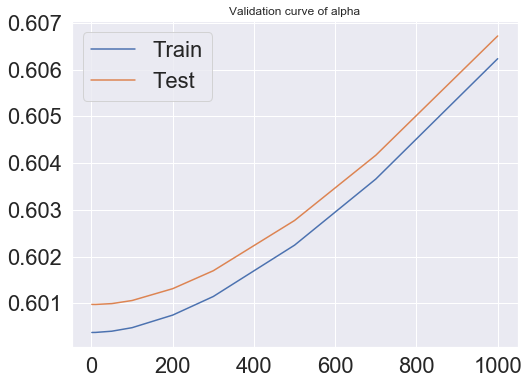

In [110]:
ridge = Ridge(random_state=42)

# 하이퍼파라미터 조정
param_name='alpha'
param_range = [1, 10, 50, 100, 200, 300, 500, 700, 1000]
scoring='neg_mean_squared_error'

curve = validation_curve(ridge, data_prepared, y_train,
                         scoring=scoring, cv=5, param_name=param_name,
                         param_range=param_range, n_jobs=-1)

n = len(param_range)
plot_validation_curve(curve, param_range, param_name, scoring)

선형 회귀가 위의 데이터에서는 적합하지 않으므로 릿지회귀 역시 마찬가지

### Support Vector Regression

In [112]:
from sklearn.svm import SVR

svr = SVR(degree=2)
param_grid = {
    'C': [1, 10, 50, 100]
}
scoring = 'r2'
grid = GridSearchCV(svr, param_grid, scoring=scoring, n_jobs=-1, cv=3, verbose=3)
grid.fit(data_prepared, data_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.9min remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min finished
c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=2,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=-1, param_grid={'C': [1, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=3)

In [113]:
print(grid.best_params_)

{'C': 10}


In [114]:
svr = grid.best_estimator_
scores = cross_val_score(svr, data_prepared, data_labels, n_jobs=-1, cv=5, scoring='r2')
print('R2: ', np.sqrt(scores).mean())

R2:  0.8780119560259483


### Decision Tree

In [115]:
from sklearn.tree import DecisionTreeRegressor

desc_reg = DecisionTreeRegressor(random_state=42)
scores = cross_val_score(desc_reg, data_prepared, y_train, n_jobs=-1, cv=5, scoring='r2')
print('R2: ', np.sqrt(scores).mean())

R2:  0.7574520848993828


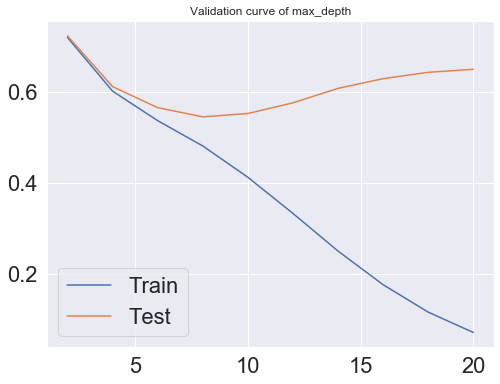

In [116]:
desc_reg = DecisionTreeRegressor(random_state=42)
param_name = 'max_depth'
param_range = range(2, 21, 2)
scoring = 'neg_mean_squared_error'
curve = validation_curve(desc_reg, data_prepared, y_train, scoring=scoring, 
                         cv=5, param_name=param_name, param_range=param_range, n_jobs=-1)
plot_validation_curve(curve, param_range, param_name, scoring)

max_depth가 8이상부터는 과적합이 보임. 3~8이 적합

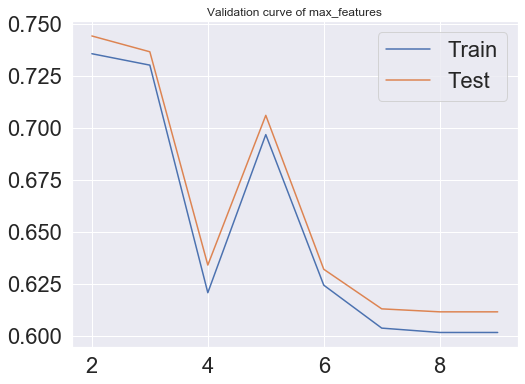

In [117]:
desc_reg = DecisionTreeRegressor(max_depth=4,random_state=42)
param_name = 'max_features'
param_range = range(2,10)
scoring = 'neg_mean_squared_error'
curve = validation_curve(desc_reg, data_prepared, y_train, scoring=scoring,
                         cv=5, param_name=param_name, param_range=param_range, n_jobs=-1)
plot_validation_curve(curve, param_range, param_name, scoring)

max_features는 6부터 9까지가 제일 좋아보임

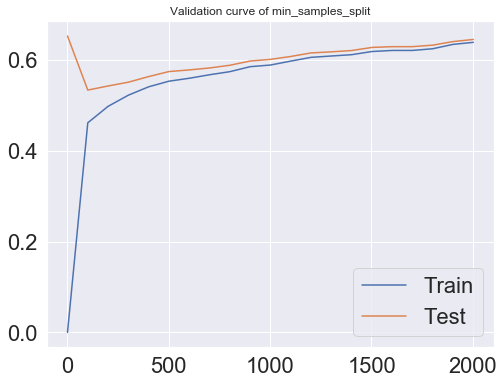

In [118]:
desc_reg = DecisionTreeRegressor(random_state=42)
param_name = 'min_samples_split'
param_range = range(2, 2003, 100)
scoring = 'neg_mean_squared_error'
curve = validation_curve(desc_reg, data_prepared, y_train, scoring=scoring, cv=5,
                         param_name=param_name, param_range=param_range, n_jobs=-1)
plot_validation_curve(curve, param_range, param_name, scoring)

min_samples_split은 200이후로 분포는 감소 

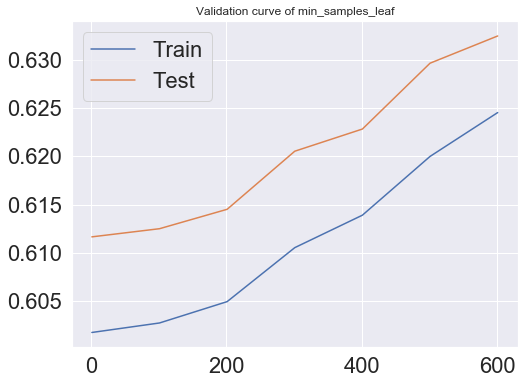

In [119]:
desc_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
param_name = 'min_samples_leaf'
param_range = range(1,701,100)
scoring = 'neg_mean_squared_error'
curve = validation_curve(desc_reg, data_prepared, y_train, scoring=scoring, cv=5,
                         param_name=param_name, param_range=param_range,n_jobs=-1)
plot_validation_curve(curve, param_range, param_name, scoring)

min_samples_leaf는 과적합을 줄이기에는 좋은 요소가 아님.

### Gradient Boosting Regression

In [120]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
param_grid={
    'n_estimators':[100],
    'max_depth':range(3,9,1),
    'max_features':[6,7,9],
    'min_samples_split':[200,400]  
}
scoring = 'r2'
grid = GridSearchCV(gbr, param_grid, scoring=scoring, n_jobs=-1, cv=3, verbose=1)
grid.fit(data_prepared, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.1min finished
c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'max_depth': 8, 'max_features': 6, 'min_samples_split': 200, 'n_estimators': 100}


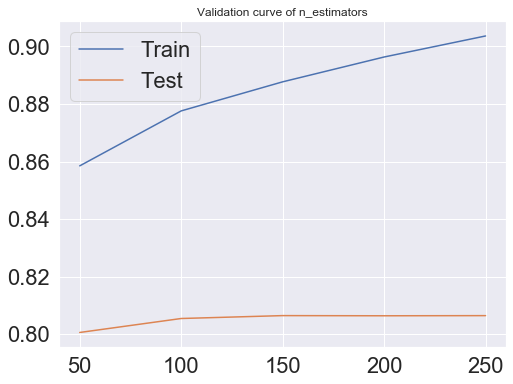

In [121]:
gbr = GradientBoostingRegressor(max_depth=8, max_features=6, min_samples_split=200, random_state=42)
param_name = 'n_estimators'
param_range = range(50,251,50)
scoring = 'r2'
curve = validation_curve(gbr, data_prepared, y_train, scoring=scoring, cv=5,
                         param_name=param_name, param_range=param_range, n_jobs=-1)
plot_validation_curve(curve, param_range, param_name, scoring)

In [122]:
gbr = GradientBoostingRegressor(max_depth=8, max_features=6, min_samples_split=200, n_estimators=100, random_state=42)
scores = cross_val_score(gbr, data_prepared, y_train, n_jobs=-1, cv=5, scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.8974790145435815


### Stacking

In [136]:
from mlxtend.regressor import StackingRegressor

lr = LinearRegression()
svr = SVR(degree=2, C=10)
gbr = GradientBoostingRegressor(max_depth=8, max_features=6, min_samples_split=200, n_estimators=100, random_state=42)

ImportError: cannot import name 'StackingRegressor' from 'sklearn.ensemble' (c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\__init__.py)

In [ ]:
sr = StackingRegressor([lr, gbr], svr, verbose=3)
scores = cross_val_score(sr, data_prepared, data_labels, n_jobs=-1, cv=3, scoring='r2')
print('R2: ',np.sqrt(scores).mean())